In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings("ignore")

# Load file
file_path = "archive/GlobalWeatherRepository.csv"  # change to your path
df = pd.read_csv(file_path)

# Use correct datetime column
date_col = "last_updated"
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
print("Date range:", df[date_col].min(), "to", df[date_col].max())
print("Unique days:", df[date_col].dt.date.nunique())


Date range: 2024-05-16 01:45:00 to 2025-08-15 21:15:00
Unique days: 456


In [35]:
# Fill numeric NaNs with median
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill categorical NaNs with mode
cat_cols = df.select_dtypes(exclude=[np.number]).columns
for col in cat_cols:
    if df[col].isna().any():
        mode_val = df[col].mode()
        df[col] = df[col].fillna(mode_val.iloc[0] if not mode_val.empty else "unknown")

# Remove duplicates
df = df.drop_duplicates()


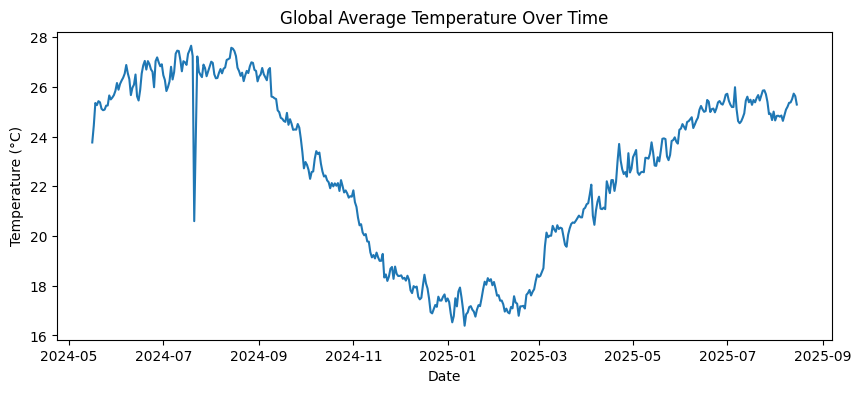

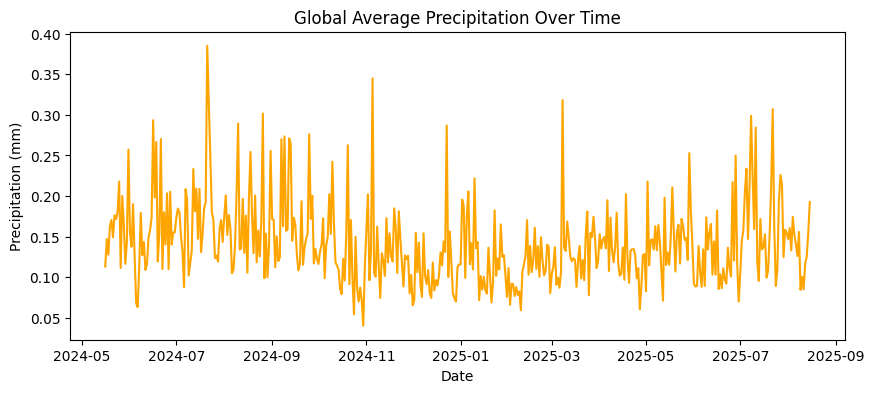

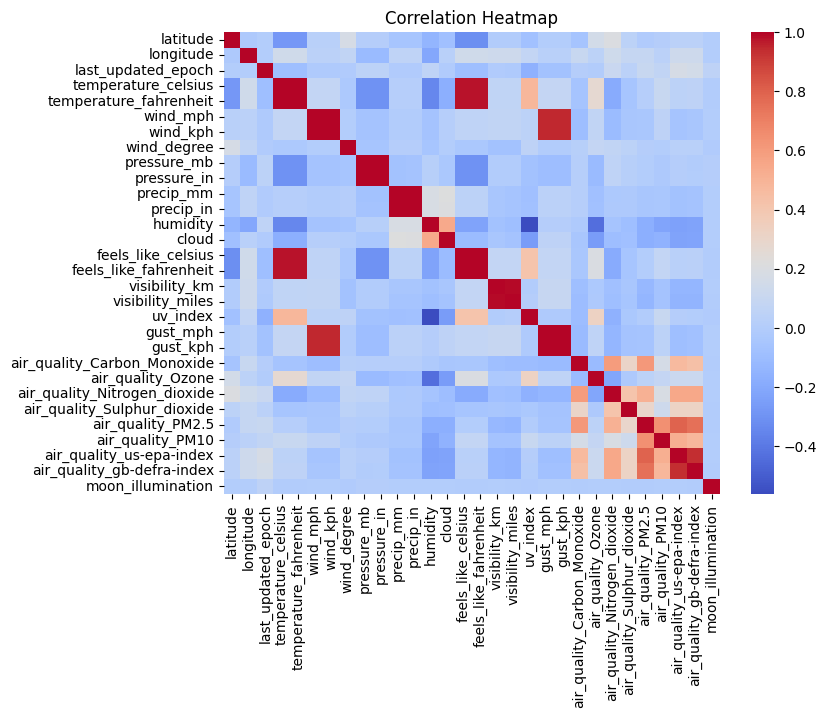

In [36]:
temp_col = "temperature_celsius"
precip_col = "precip_mm"

# Daily aggregation
daily = df.groupby(df[date_col].dt.date).agg(
    {temp_col: "mean", precip_col: "mean"}
).reset_index()
daily[date_col] = pd.to_datetime(daily[date_col])

# Plot Temperature
plt.figure(figsize=(10,4))
plt.plot(daily[date_col], daily[temp_col])
plt.title("Global Average Temperature Over Time")
plt.xlabel("Date"); plt.ylabel("Temperature (°C)")
plt.show()

# Plot Precipitation
plt.figure(figsize=(10,4))
plt.plot(daily[date_col], daily[precip_col], color="orange")
plt.title("Global Average Precipitation Over Time")
plt.xlabel("Date"); plt.ylabel("Precipitation (mm)")
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [37]:
city_col = "location_name"
chosen_city = df[city_col].value_counts().index[0]
print("Forecasting for:", chosen_city)

city_df = df[df[city_col] == chosen_city]
ts = city_df.groupby(city_df[date_col].dt.date)[temp_col].mean().reset_index()
ts[date_col] = pd.to_datetime(ts[date_col])
ts = ts.set_index(date_col).asfreq("D").interpolate()

train_size = int(len(ts) * 0.8)
train, test = ts.iloc[:train_size], ts.iloc[train_size:]


Forecasting for: Kabul


In [38]:
sarima = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
sarima_fit = sarima.fit(disp=False)
sarima_pred = sarima_fit.forecast(len(test))


In [39]:
def make_lags(series, lags=[1,2,3,7]):
    df_lag = pd.DataFrame({"y": series})
    for L in lags:
        df_lag[f"lag_{L}"] = series.shift(L)
    return df_lag.dropna()

lagged = make_lags(ts[temp_col])
lag_train = lagged.loc[train.index.intersection(lagged.index)]
lag_test  = lagged.loc[test.index.intersection(lagged.index)]

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(lag_train.drop(columns="y"), lag_train["y"])
rf_pred = pd.Series(rf.predict(lag_test.drop(columns="y")), index=lag_test.index)


In [41]:
from math import sqrt
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return sqrt(mean_squared_error(a, b))

print("SARIMA RMSE:", rmse(test[temp_col], sarima_pred))
print("RF RMSE:", rmse(test[temp_col], rf_pred))
print("Ensemble RMSE:", rmse(test[temp_col], ensemble_pred))


SARIMA RMSE: 5.290087950954235
RF RMSE: 1.411363218331113
Ensemble RMSE: 2.7921439583866747


Anomalies detected: 887


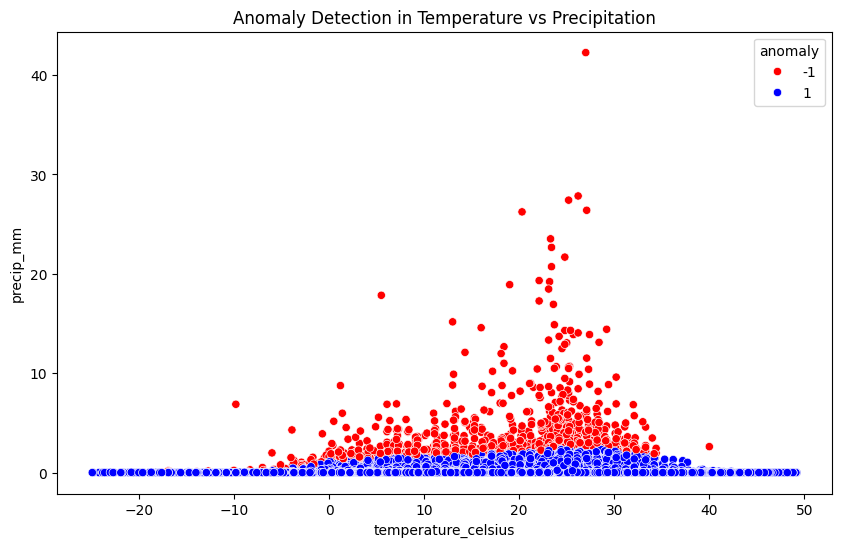

In [43]:
# Anomaly detection for temperature and precipitation
features = ['temperature_celsius', 'precip_mm']
df_anomaly = df.dropna(subset=features)

iso = IsolationForest(contamination=0.01, random_state=42)
df_anomaly['anomaly'] = iso.fit_predict(df_anomaly[features])

# -1 = anomaly, 1 = normal
print("Anomalies detected:", (df_anomaly['anomaly'] == -1).sum())

# Plot anomalies
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_anomaly, x='temperature_celsius', y='precip_mm', hue='anomaly', palette={1: 'blue', -1: 'red'})
plt.title("Anomaly Detection in Temperature vs Precipitation")
plt.show()


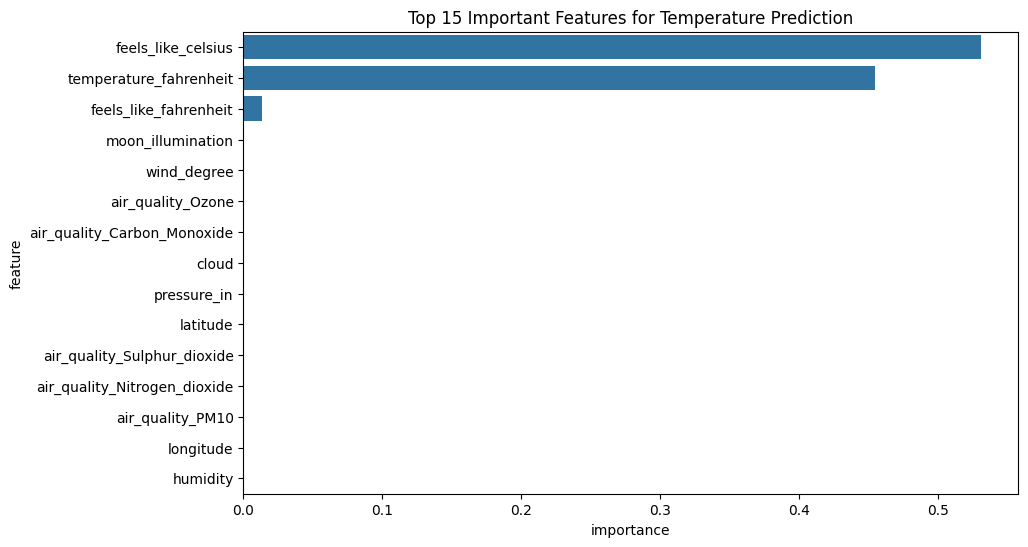

In [44]:
# Select numeric features for importance
numeric_cols = df.select_dtypes(include=[np.number]).drop(columns=['last_updated_epoch']).columns
X = df[numeric_cols].dropna()
y = X.pop('temperature_celsius')

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

importances = rf_model.feature_importances_
feat_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances}).sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=feat_importance_df.head(15), x='importance', y='feature')
plt.title("Top 15 Important Features for Temperature Prediction")
plt.show()
